# 基于膜的细胞分割后处理
在这个笔记本中，我们使用来自[napari-segment-blobs-and-things-with-membranes](https://github.com/haesleinhuepf/napari-segment-blobs-and-things-with-membranes)的种子分水岭算法来分割细胞，然后对细胞进行过滤以去除错误分割的对象。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread

import pyclesperanto_prototype as cle
import napari_segment_blobs_and_things_with_membranes as nsbatwm

以下示例图像数据是标记有膜标记物的细胞的时间序列。该数据集由德累斯顿MPI-CBG的Nadler实验室的Sascha M. Kuhn提供。

In [2]:
image_timelapse = imread("../../data/membrane_2d_timelapse.tif")
image_timelapse.shape

(5, 256, 256)

我们首先从时间序列堆栈的中间提取单个通道、单个时间点的示例。

In [3]:
membranes_single_slice = image_timelapse[2]
membranes_single_slice.shape

(256, 256)

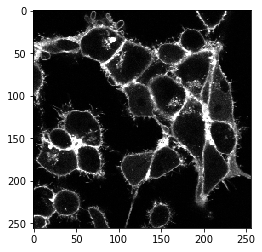

In [4]:
cle.imshow(membranes_single_slice)

napari-segment-blobs-and-things-with-membrances插件是可脚本化的。所有可以从菜单调用的命令也可以从Python调用。例如，局部最小值种子分水岭可以这样调用：

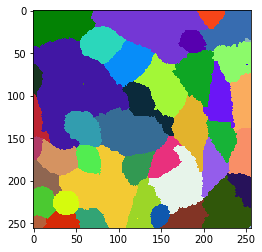

In [5]:
cell_labels_pre = nsbatwm.local_minima_seeded_watershed(membranes_single_slice, spot_sigma=7)

cle.imshow(cell_labels_pre, labels=True)

显然，在这一步之后分割和标记的对象太多了。因此，我们应该探索这些细胞的哪些属性允许我们区分真实细胞和分割的背景。例如，由于细胞在前后也有膜，我们在真实细胞中感知到这个信号的强度更高。为了定量地可视化这一点，我们绘制了细胞的平均强度图。在这张图中，属于给定细胞的每个像素都获得整个细胞的平均信号强度。

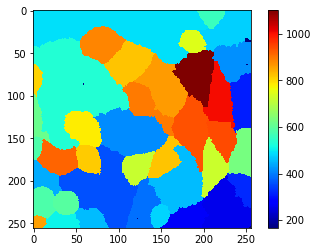

In [6]:
mean_intensity_map = cle.mean_intensity_map(membranes_single_slice, cell_labels_pre)

cle.imshow(mean_intensity_map, colorbar=True, colormap='jet')

从这个视图和侧边的颜色条我们可以猜测一个阈值，例如`650`，它允许我们将真实细胞与背景分开。如果这种简单的阈值方法不起作用，和/或单个参数如平均强度不允许这种区分，使用对象分类器（也就是机器学习）可能会更有意义。例如，[napari-accelerate-pixel-and-object-classification](https://www.napari-hub.org/plugins/napari-accelerated-pixel-and-object-classification)插件和底层的[apoc库](https://github.com/haesleinhuepf/apoc)可以提供帮助。

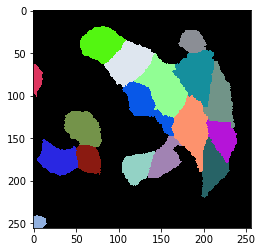

In [7]:
cell_labels = cle.exclude_labels_with_map_values_within_range(mean_intensity_map, cell_labels_pre, maximum_value_range=700)

cle.imshow(cell_labels, labels=True)

## 将工作流应用于整个时间序列
我们现在对如何分割细胞的工作流程有了大致的了解。我们将整个工作流程重写为一个函数。该函数还有适当的文档，以便未来的自己仍然知道该函数的作用。

In [8]:
def cell_segmentation_worflow(membranes_single_slice, cell_segmentation_spot_sigma=7, maximum_mean_intensity_per_cell=700):
    """基于膜信号的细胞分割
    
    参数
    ----------
    membranes_single_slice
        要分割的图像
    cell_segmentation_spot_sigma: float, 可选
        允许配置分割。sigma越高，细胞数量越少。
    maximum_mean_intensity_per_cell: float, 可选
        每个细胞的平均强度阈值。信号低于此值的细胞将被排除
        
    返回
    -------
    细胞标签图像
    """
    
    # 标记细胞候选
    cell_labels_pre = nsbatwm.local_minima_seeded_watershed(
                                membranes_single_slice, 
                                spot_sigma=cell_segmentation_spot_sigma)
    
    # 测量所有候选的强度
    mean_intensity_map = cle.mean_intensity_map(
                                membranes_single_slice, 
                                cell_labels_pre)
    
    # 排除信号低的候选
    cell_labels = cle.exclude_labels_with_map_values_within_range(
                        mean_intensity_map, cell_labels_pre, 
                        maximum_value_range=maximum_mean_intensity_per_cell)
    
    return cell_labels

我们可以将这个函数应用于整个时间序列，并查看分割是否在所有时间点上都运行良好。

t =  0 , number of cells:  17.0


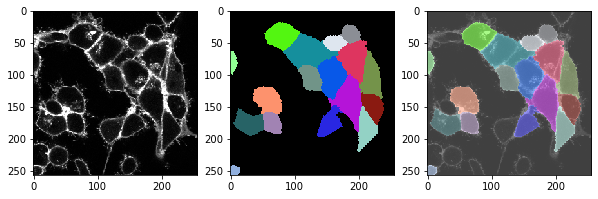

t =  1 , number of cells:  18.0


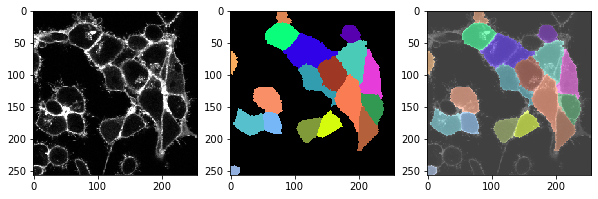

t =  2 , number of cells:  17.0


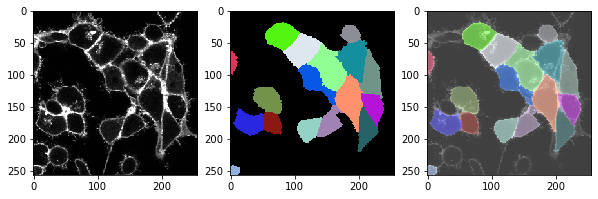

t =  3 , number of cells:  18.0


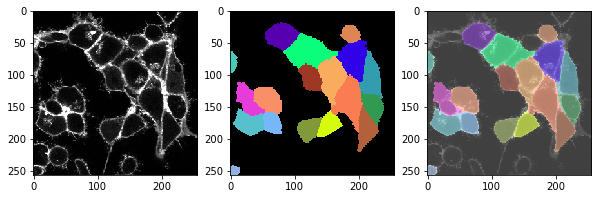

t =  4 , number of cells:  17.0


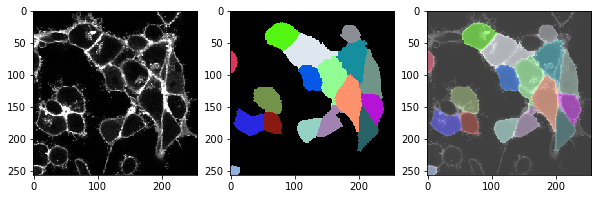

In [9]:
for t in range(len(image_timelapse)):
    # 提取单个切片/时间点
    membranes_single_slice = image_timelapse[t]
    
    # 分割细胞
    cell_labels = cell_segmentation_worflow(membranes_single_slice)

    # 打印标题
    print("t = ", t, ", 细胞数量: ", cell_labels.max())
    
    # 显示三张图像：图像、标签、叠加
    fix, axs = plt.subplots(1, 3, figsize=(10,10))
    
    cle.imshow(membranes_single_slice, plot=axs[0])
    cle.imshow(cell_labels, plot=axs[1], labels=True)
    cle.imshow(membranes_single_slice, plot=axs[2], alpha=0.5, continue_drawing=True)
    cle.imshow(cell_labels, plot=axs[2], labels=True, alpha=0.5)
    plt.show()
    

## 练习
不要过滤掉信号强度低的细胞，而是过滤掉大的和/或接触图像边界的细胞。将新的工作流程应用于整个时间序列。